In [2]:
from IPython.display import display
from PIL import Image  
from IPython.display import HTML
from PIL import Image
import matplotlib.pyplot as plt

# Mobile Robotics Project (EPFL) - Report Group 31


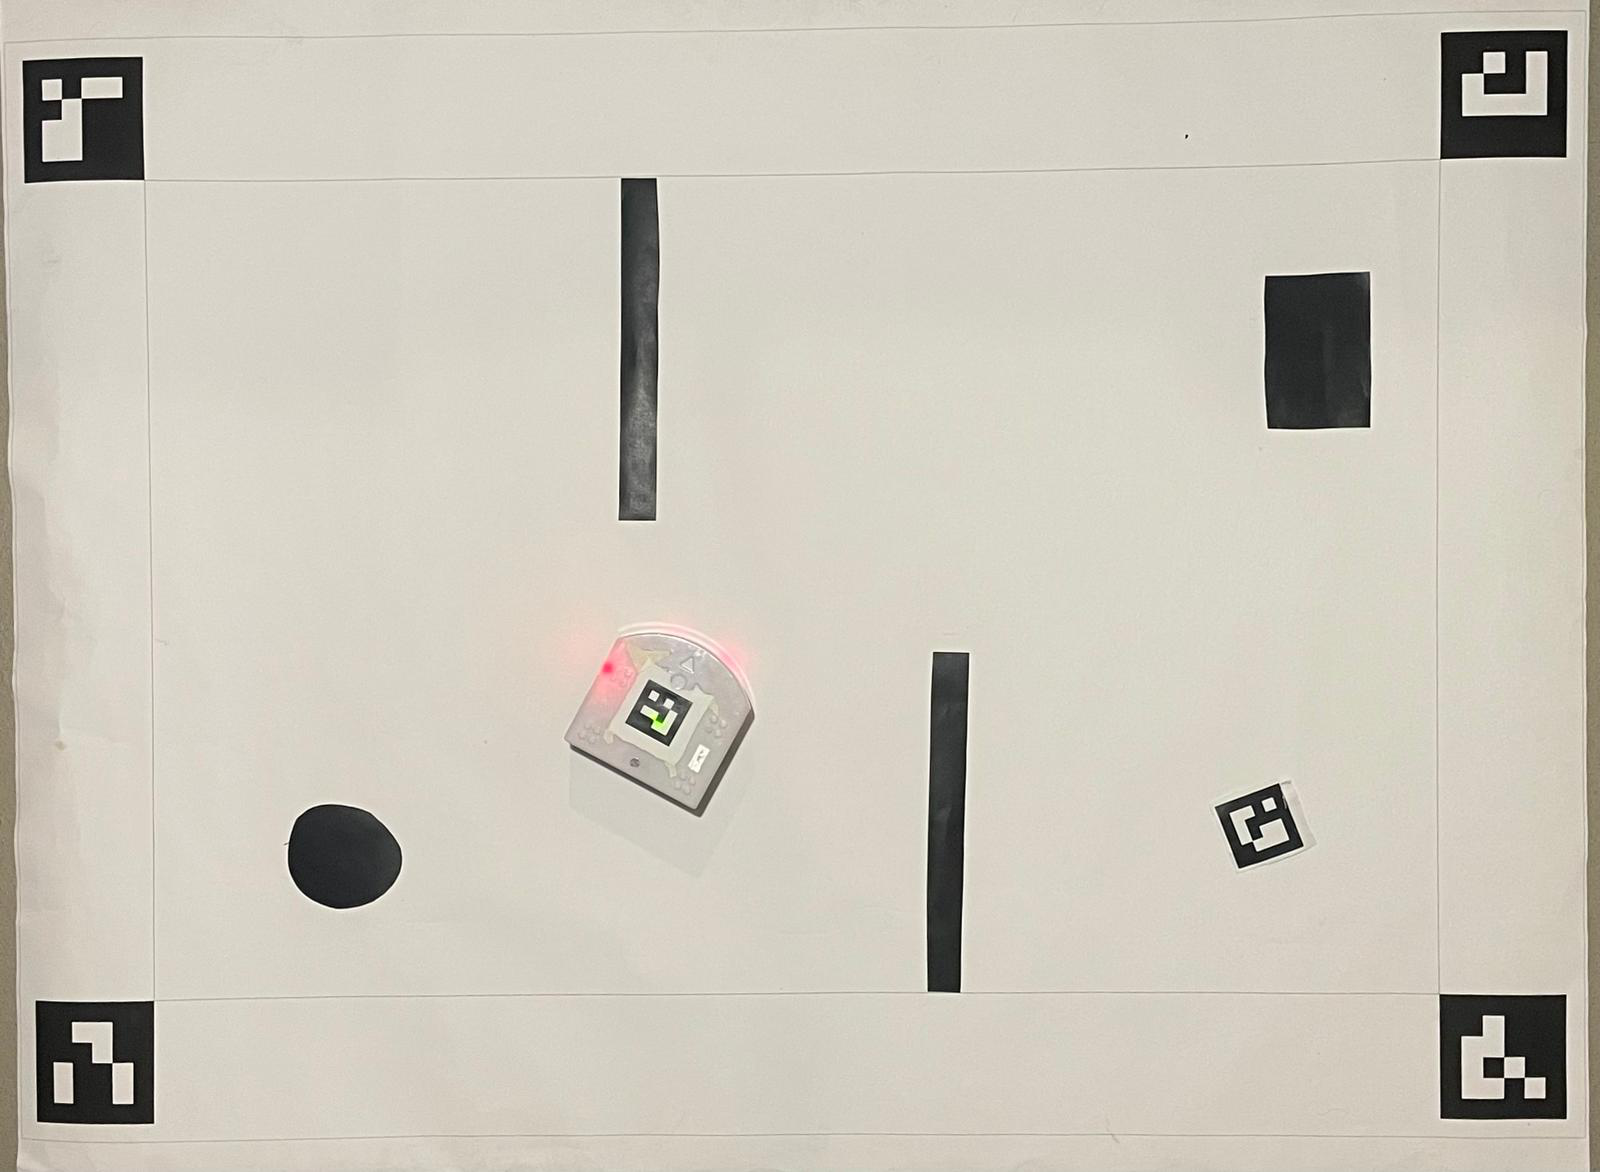

In [20]:
img = Image.open("images/photo_couverture.png")
display(img)

## 1. Introduction

The aim of this report is to present the work carried out as part of our “Mobile Robotics” project at EPFL. Our team is composed of 4 students from the Robotics Master: 

Christian Matala:    327317

Samy Gaillard:       394663
 
Alix Papadatos:      347263
  
Zacharie Bourlard:   329920

### a. Project's goal

This project focuses on implementing both global and local navigation for a Thymio robot. The goal is to enable the robot to navigate efficiently toward a target while avoiding obstacles on the map and any dynamic obstacles that may appear. The key features of our implementation include:

- Reliable map creation and feature detection using ArUco markers.
- Generation of a visibility graph that connects obstacle corners, the Thymio's position, and the target point.
- Calculation of the optimal path using the A* algorithm.
- Automatic detection and connection to the Thymio's port.
- Dynamic path-following and regulation to maintain accuracy.
- Detection of "kidnapping" scenarios for both the robot and the target.
- Automatic map and path updates in case of target relocation or kidnapping situations.
- Implementation of a Kalman filter for navigation when the camera measurements are unavailable.
- Local obstacle avoidance using a neural network.

### b. Project's constraints

**Imposed Material:**
- Use of the Thymio Robot 
- Use of the supplied camera

**Global motion constraints:**
- Vision: 
    - Environment generation
    - Best path generation
    - Fixed obstacles avoidance 
- Filtering (position estimation)
- Local obstacles avoidance

**Additionnal challenges:**
- Good response to "Kidnapping" of the robot
- Good response to end-point displacement
- Good response to camera obstruction (showing good filtering)

### c. Setup

**Picture of our setup:**

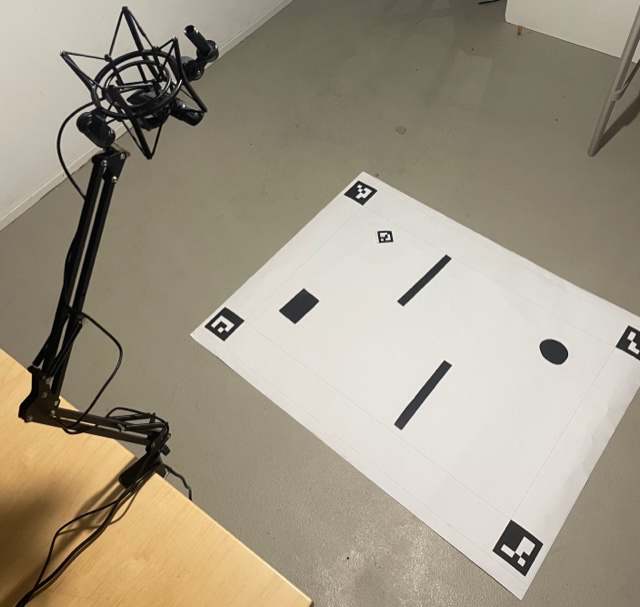

In [72]:
img = Image.open("images/setup.png")
display(img)

We thought our setup with the idea in mind to create a stable setup that can be installed in many different conditions. We didn't want to be dependent on the level or shade of lighting in the room we were in. So we didn't want to distinguish our robot, obstacles and the boundaries of our environment by color, but rather by geometric distinctions: the Aruco codes. This is how we created the **map** that can be seen in the picture above.

To fix the camera, we used a microphone **tripod** that allowed us to be very flexible concerning the possible locations where we can install our setup. 

### d. General organization of the code

#### i. Relationships between modules

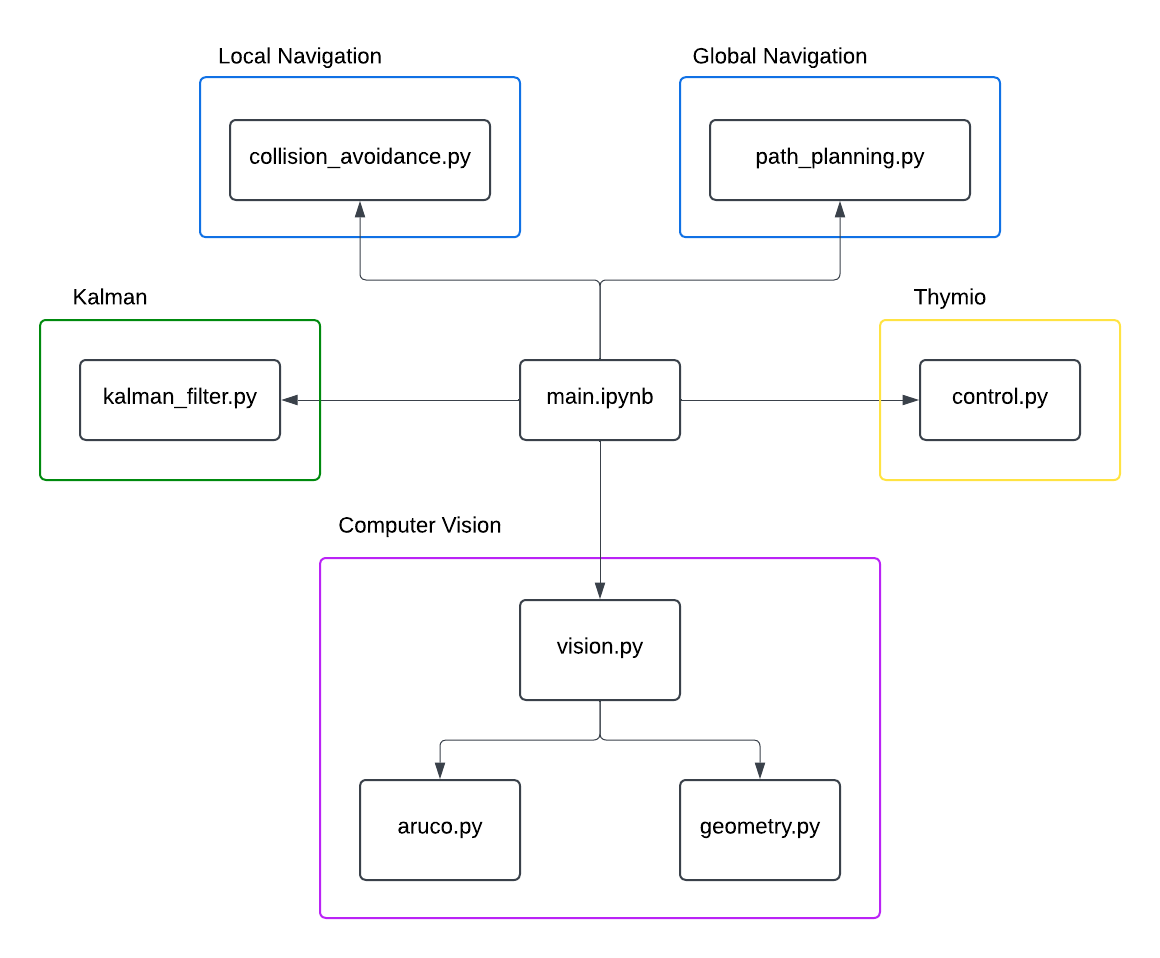

In [19]:
img = Image.open("images/Module relationships.png")
display(img)

#### ii. Code's Systematic Execution 

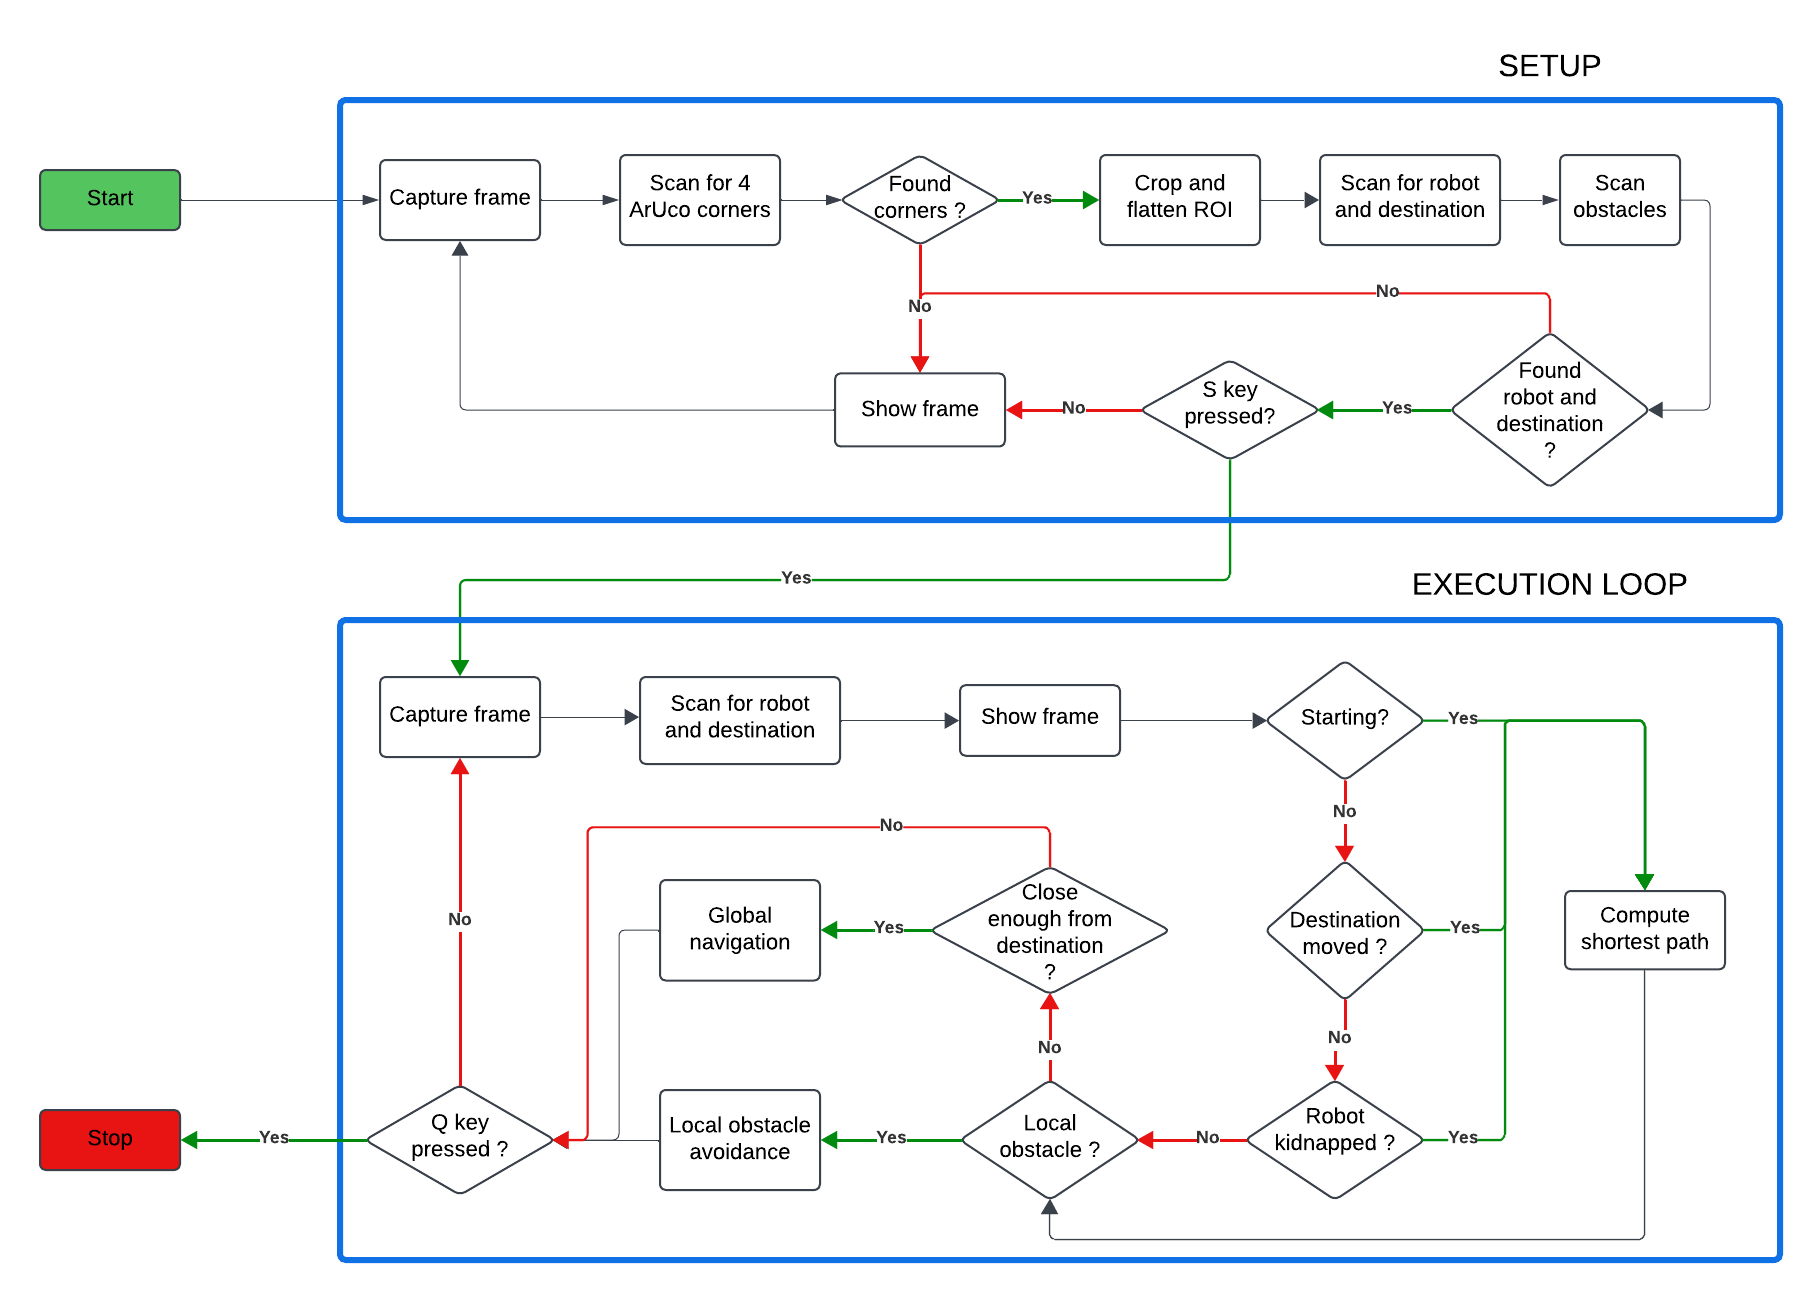

In [18]:
img = Image.open("images/Main graph.png")
display(img)

## 2. Computer Vision

In this part we will analyze the structure of the Computer vision implementation for our project. For this we will start by enumerating the different external libraries that we used, then we will explain how we initialize our scene in our code, to finally detail the methods used to detect the obstacle, the robot and the destination.

### 2.1 External Libraries

In computer vision we used external libraries to help us in various tasks, we thus reference them here before introducing our implementation.

We used:
1. OpenCV-Contrib-Python which is a library that contains all opencv functions plus some funcitons added by contributors. OpenCV provided a rich set of functions that helped us process the images of our camera. Note that **every** OpenCV function used is referenced in the source section, with a link to the function documentation.
2. Numpy library for its easy data structures and mathematical operations.
3. Aruco library to handle the detection of our Aruco tags.
4. Scipy to handle transformation between rotation matrixs,quaternions and Euler angles.

NOTE: from now on the term "tag" or "marker" refers to ArUCo Markers

### 2.2 Class Definition

The goal of the computer vision module is to process the images taken by the camera to create our map and essential variables. For the scene, we chose to create a Map class, which will be in charge of handing every vision variable and functions as attributes and methods, as shown below (which only contains the class attributes, the methods will be shown further below):

In [73]:
import cv2 as cv
from constants import *

class Map:
    def __init__(self):
        # Initialilze camera video capture
        self.capture = cv.VideoCapture(0)
        # Drop the first x frames
        for _ in range(FIRST_FRAME):
            self.capture.read()
        
        # Define class attributes
        self.success = True
        self.raw_frame = None
        self.frame = None
        self.robot = 3*[None]
        self.destination = 3*[None]
        self.map_corners = {}
        self.found_corners = False
        self.found_robot = False
        self.found_destination = False
        self.obstacles = []
        self.edges = None
        self.obstacles_lines = []
        self.target_lines = []
        self.pose_est = 3*[None]

- The Map class starts by initializing a capture for our camera to take pictures from, using opencv's method VideoCapture.
- Then it drops the first X frame to let the camera adapt its settings to the environment.
- It then initializes the rest of the class attributes:
1. success: False if it fails an image treatment
2. raw_frame: Raw captured frame of the camera
3. frame: Raw frame treated
4. robot: Contains the robot position in (x,y) and its orientation.
5. destination: Contains the destination's position in (x,y) and the corners of the detected aruco tag
6. map_corners: if the aruco tags in the corners are detected, this maps them to the pixel that we will use to crop the image
7. found_corners: is true if the aruco tags in the corners are detected
8. found_robot: is true if the robot tag is detected
9. found_destination: is true if the destination tag is detected
10. edges: stores the edges frame from our Canny transformation, for visualization
11. obstacles: list of obstacles, each defined as a list of points
12. possible_lines: list of lines of the computed visibility graph
13. target_lines: list of points that creates the computed shortest path
14. pose_est: position estimation of the kalman filter

We also defined multiple simple helper functions such as:
1. info()
2. snap()
3. update()
4. show()

The detailed use of these functions is commented in the code but their name was kept short and self explanatory to facilitate their use in the main module. We also made these functions callable without any parameters to let the vision module handle everything at once, for example the update method is simply called in the main module and takes care to call all the appropriate vision methods that we want to update.

### 2.3 Scene initialization

When the program starts in our main, the first thing that is done is the creation of our Map instance. Once created we first enter our setup phase. This is because before we start the main execution loop we want to place and adjust our robot, our destination and our obstacles on the scene. During this "setup" phase this part of the code lets us see what the camera has detected, to make sure everything is properly set.

The code below shows how we implemented this on the main:

In [ ]:
map = Map()
if P_VISION:
    print(P_SETUP)
    print("Place the Thymio and the destination, check that everything is properly set. Then, press S.")

# Call a first single update step to create our vision windows
map.update(True) 

while True:
    
    if keyboard.is_pressed('space'):
        map.update(True)
    
    if keyboard.is_pressed('s'):
        if map.found_corners and map.found_destination:
            map.update()
            break
        else:
            print("USER: Must find corners before start")
    
    cv.waitKey(10)

The code below shows the code implementation of the update method:

In [ ]:
def update(self, setup=False):
    # Capture a new frame and update the class attributes
    self.snap()
    if setup:
        self.find_corners()
        if self.found_corners:
            self.find_thymio_destination()
            self.pose_est = self.robot.copy()
            self.detect_global_obstacles()
    else:
        self.find_thymio_destination()

    self.show()

(Note that we only have one update function, which takes care of updating our scene for both setup and execution phase. This is done by passing a setup argument (which is False by default to keep zero argument when calling it in our main) )

#### 2.3.1 Detecting the four ArUco corner tags
On the setup phase, the first step is to detect the four ArUco tags in the corners of our map. These four corners are essential as they allow us to crop out the inner rectangle, we from now is defined as the Region Of Interest, or ROI. We chose to use the 4x4 ArUco dictionary in this project, which is sufficient to be detected by our camera. The tags and their corresponding ids are displayed below:

<h5>ArUco 4x4 Dictionary</h5>

<table>
  <tr>
    <th>ID 0</th>
    <th>ID 1</th>
    <th>ID 2</th>
    <th>ID 3</th>
    <th>ID 4</th>
    <th>ID 5</th>
  </tr>
  <tr>
    <td><img src="./images/Arucos/4x4-0.png" alt="4x4-0" width="80"></td>
    <td><img src="./images/Arucos/4x4-1.png" alt="4x4-1" width="80"></td>
    <td><img src="./images/Arucos/4x4-2.png" alt="4x4-2" width="80"></td>
    <td><img src="./images/Arucos/4x4-3.png" alt="4x4-3" width="80"></td>
    <td><img src="./images/Arucos/4x4-4.png" alt="4x4-4" width="80"></td>
    <td><img src="./images/Arucos/4x4-5.png" alt="4x4-5" width="80"></td>
  </tr>
</table>



#### 2.3.2 Cropping and flattening the scene

The setup phase also takes care of detecting the 4 aruco tags in the corners which define our region of interest, to then crop and flatten it out of the raw captured frame using the flatten_scene() method. This code of this method is shown below:

In [ ]:
def flatten_scene(self):
    # From the four detected aruco corners, crop out and flatten our region of interest using opencv
    inner_corners = np.array([
        self.map_corners['top_left'],
        self.map_corners['top_right'],
        self.map_corners['bottom_right'],
        self.map_corners['bottom_left']
    ], dtype="float32")

    destination_corners = np.array([
        [0,0],
        [SCREEN_WIDTH-1,0],
        [SCREEN_WIDTH-1, SCREEN_HEIGHT-1],
        [0, SCREEN_HEIGHT-1]
    ], dtype="float32")
    
    try:
        M = cv.getPerspectiveTransform(inner_corners,destination_corners)
        self.frame = cv.warpPerspective(self.raw_frame,M,(SCREEN_WIDTH,SCREEN_HEIGHT))
    except Exception as e:
        if P_VISION: print("ERROR: warpPerspective")
        self.success = False

We used the OpenCV functions getPerspectiveTransform() and warpPerspective().

* **getPerspectiveTransform**: Computes a 3x3 perspective transformation matrix M that maps four source points (corners previously detected) to four destination points (corners of our output vision window).

* **warpPerspective**: Applies the perspective transformation matrix M computed by getPerspectiveTransform, to warp the given frame.

**IMAGE OF THE FLATTEN AND RAW SCENE**

The final cropped and flattened frame is set as our frame class attribute. It is this attribute that will be used for all our vision image processing. This allows us to only focus our processes on the map, to exlude any imperfect environment that could appear on the frame outside our ROI. It also provides modularity to our project as it does not predefine a map dimension. Our vision is thus capable of extracting maps of various sizes to flatten it into our vision window, with predefined pixel dimensions. Those dimensions are defined in the constants module, shown below:

In [ ]:
# METRICS
SCREEN_WIDTH = 640
SCREEN_HEIGHT = 480
MAP_HEIGHT_CM = 62.5
MAP_WIDTH_CM = 97.2
ROBOT_RADIUS_CM = 12
PIXEL_PER_CM = SCREEN_WIDTH/MAP_WIDTH_CM
ROBOT_RADIUS_PIXEL = int(ROBOT_RADIUS_CM * PIXEL_PER_CM)
TARGET_RADIUS_PIXEL = int(100 * MARKER_SIZE_ROBOT * PIXEL_PER_CM)

Note that we just need to give the dimension of the map in order to compute the number of pixels per centimeters. Defining constants as suchs allows our code to be modular to any map and window size, as it dynamically computes the pixels to centimers scale.

**IMAGES OF THE VISION SETUP WINDOWS**

### 2.4 Detection of the Robot and the Destination

The robot and the destination are detectable by the camera with ArUco markers: the robot has a 4x4 ArUco of id 4 on its back, and the destination is a 4x4 ArUco of id 5, all illustrated below.

<img src="Images/Robot marker.jpg" alt="Alt text" width="300"/>
<img src="Images/Destination marker.jpg" alt="Alt text" width="300"/>

These markers are detected with the Map class method get_rt_arucos, which uses the same aruco detection function from OpenCV: detectMarkers(). The call of the OpenCV function is shown below:

In [ ]:
# Detect ArUco markers in the frame
(corners, ids, rejected) = cv.aruco.detectMarkers(
    frame, aruco_dictionary, parameters=aruco_parameters)

detectMarkers() takes the frame to treat, the aurco dictionary (which maps the marker pattern to an id) and the ArUco parameters which is the set of parameters used by the ArUco marker detection process that control its behavior.

Once detected by the OpenCV function, **get_rt_arucos** returns the position of the marker in pixels.

#### 2.4.1 Computing the angle of the robot

For the robot marker it also returns the angle of the marker, computed by the OpenCV method **estimatePoseSingleMarkers()**. The call of this function is shown below:

In [ ]:
# Get the rotation and translation vectors
rvecs, tvecs, obj_points = cv.aruco.estimatePoseSingleMarkers(
    corners,
    marker_size,
    camera_matrix,
    dist_coeffs)

As shown above, this function takes the corners detected by the detectMarkers function, the ArUco code size in meter (defined in constants) and the camera matrix and distance coefficients, which are the camera calibration variables from the camera_calibration.yaml file. It returns rotation and translation vectors: **rvecs** and **tvecs**. We then convert the 3D rotation vector into a 3x3 rotation matrix using the Rodrigues formula [x]. The rotation matrix is then passed to **get_rotation**, a function defined in the geometry module that convert the it into euler angles (the description of the function is commented in the geometry module). This is done with the code below, taken from the get_rt_arucos function:

In [ ]:
rotation_matrix = cv.Rodrigues(np.array(rvecs[i][0]))[0]
(rx,ry,rz) = get_rotations(rotation_matrix)

#### 2.4.2 Structure returned

Finally, the structure returned by get_rt_arucos() is a dictionary that maps the id of the markers to its corresponding data:

{ AT_ROBOT : [center_x, center_y,angle],
  AT_DESTINATION : [center_x, center_y, corners]}

With AT_X being the corresponding AruCo tag id, angle the computed robot angle, and corners the corners points of the destination aruco tag.
The corners of the destination will be used in our show() method to display a red cross on the destination ArUco tag.

### 2.5 Detection of global obstacles

In this section we will analyze how we performed our global obstacles detection through methods of our Map class. The method that handles this is called detect_global_obstacles(), it's code can be shown below (the code cells are shown progressively, every code cell of section 2.4.1 is the code of this method, in order):

In [ ]:
def detect_global_obstacles(self):
    # Clear previous obstacles
    self.obstacles = []
    # Create local copy of the frame that we will use for treatment
    frame = self.frame.copy()
    # Convert to grayscale
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Blur the image
    frame = cv.GaussianBlur(frame, (5, 5),0)
    # Detect edges
    frame = cv.Canny(frame, 50, 150)
    # Detect contours
    contours, _ = cv.findContours(frame, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    # Store edge detection
    self.edges = frame
    # Remove area out of range obstacles
    contours = [contour for contour in contours if MIN_AREA <= cv.contourArea(contour) <= MAX_AREA]
    # Approximate the contour to a polygon and extract corners
    for contour in contours:
        epsilon = 0.025 * cv.arcLength(contour, True)  # 2.5% of the perimeter
        approx_corners = cv.approxPolyDP(contour, epsilon, True)

        if len(approx_corners) >= 3:  # Ensure it's a valid polygon
            corners = approx_corners.reshape(-1, 2) # Extract the corners
            corners = remove_close_points(corners) # Remove duplicates
            corners = augment_corners(corners) # Compute augmented obstacle
            valid_obstacle = not on_points(corners,
                                            [self.found_robot,self.found_destination],
                                            [self.robot[0:2],self.destination[0:2]],
                                            [MIN_DIST_TO_ROBOT, MIN_DIST_TO_DESTINATION])
            if valid_obstacle:   # Check if it is not the robot or on the destination
                self.obstacles.append(corners)  # Add the obstacles to our obstacle list


First we perform a Canny edge detection on a blurred grayscale version of a copy of the captured frame. The result of this edge detection is then stored in the edge attribute to later be shown in the show method, for visualization purposes. Then using the detected edgs we find the closed contours using the findContours method of OpenCV. Once this is done we saw that some imperfection on our image passed through our blurred image and were detected as edges, and contours. We filtered these imperfections in two steps:

#### 2.5.1 Detecting external contours:

The findContours method has three arguments: the image to treat, the mode, and the method. The mode can have different values shown in the table below, taken from the official OpenCV documentation (see Source section):

<img src="Images/Modes of  findContours.png" alt="Alt text" width="700"/>

We changed the default mode and set it to RETR_EXTERNAL to only detect the external edges, this removed any imperfections inside an obstacle to only keep the external contour.

#### 2.5.2 Filtering out contours with areas within a specified range:

Once we have a set of close external contours, we still had imperfections on the scene as very small contours. To fix this we simply defined a range of valid obstacle area to filter out those that are either too big or too small. These constants were found empirically and are defined in the constants module for modularity. The section of the code that implemented the obstacle detection constants is presented below:

In [ ]:
# OBSTACLES
MIN_OBSTACLE_SEGMENT_LENGTH = 10
MIN_AREA = 20
MAX_AREA = 180000
DISPLAY_OBSTACLES = "POINTS"
MIN_SECURITY = 2
MIN_DIST_TO_ROBOT = MIN_SECURITY*ROBOT_RADIUS_PIXEL
MIN_DIST_TO_DESTINATION = MIN_SECURITY*TARGET_RADIUS_PIXEL

With our list of valid obstacles contours, we must now transform these contours into a set of augmented points so that our robot can navigate around the obstacles. We can also divide this process into two steps: first approximating the contours into a polygon, and second augment the polygon by the radius of the robot.

#### 2.5.3 Polygon approximation from the detected contours

For this we used another OpenCV method: approxPolyDP(). The arguments of this method are shown in the table below, taken from the official OpenCV documentation:

<img src="Images/approxPolyDP.png" alt="Alt text" width="900"/>

For the epsilon parameter, we chose to give it the value of 2.5 % of the contour perimeter, which was also found empirically. Defining it as a function of the contour perimeter allows this value to be modular for every obstacle size. We must also set the closed parameter to True so that the approximated curve is closed, thus forming an approximated polygon of our continous contour.

**Problem faced**:
Due to the discontinuity of some contours, some approximated polygons contained two very close points on a corner of two discontinued segments.

To fix this we implemented a remove_close_points function, which analyses every point on the approximated polygon and removes any duplicates, defined by a point that has a distance below the given threshold. The threshold is defined as the constant MIN_OBSTACLE_SEGMENT_LENGTH in the constants module. This function was implemented in the geometry module due to its strictly mathematical operations, and is not shown here because of its simplicity.

From here we have a valid polygon approximation of the obstacle contours detected on our frame, the next step is now to augment the computed polygon.

#### 2.5.4 Augmenting obstacles polygons

To augment each obstacle polygon we first tried this simple method for each points of a given obstacle polygon:
1. Compute the center point of the polygon
2. Compute the vector from the center to the corner
3. Scale it so that its norm is equal to the robot radius in pixels

The augmented point is then obtained by adding the scaled vector to the point. The implementation and an illustration of this method is shown on below:

In [ ]:
def find_peak(corners, i):
    # Compute left and right corners
    corner = np.array(corners[i])
    left_corner  = np.array(corners[(i-1)%len(corners)])
    right_corner = np.array(corners[(i+1)%len(corners)])
    # Compute left and right vectors
    left_vector = (corner - left_corner)
    right_vector = (corner - right_corner)
    # Normalize left and right vectors
    left_vector = left_vector/np.linalg.norm(left_vector)
    right_vector = right_vector/np.linalg.norm(right_vector)
    # Sum them to get the corner vector
    corner_vector = left_vector + right_vector
    # Scale the vector to have a norm of ROBOT_RADIUS_PIXEL
    scaler = ROBOT_RADIUS_PIXEL/np.linalg.norm(corner_vector)
    corner_vector = scaler*corner_vector
    # Return the vector added to the corner
    return corner + corner_vector

<img src="Images/Wrong obstacle augmentation.jpg" alt="Alt text" width="700"/>

**Problem faced:**
We can clearly see here the problem with this method for triangular shapes: the distance is well transformed for the corners, but not the segments. This happens when the corner angle is too low. To fix this we simply added the offset segment to have both corner distance and segment distance be equal to the robot radius, this is illustrated in the figure below:

<img src="Images/Valid obstacle augmentation.jpg" alt="Alt text" width="400"/>


With these two methods combined we have 3 augmented points per corners, giving us more points, so more computation for the visibility graph, but a more robust augmentation of our obstacles, to ensure it does not pass over the obstacle.

The final code to implement this is shown below:

In [ ]:
def augment_corners(corners):
    augmented_corners = []

    # Iterate through each pair of consecutive corners
    for i in range(len(corners)):
        p1 = corners[i]
        p2 = corners[(i + 1) % len(corners)]
        
        segment_vector = p2 - p1
        perpendicular_vector = np.array([-segment_vector[1], segment_vector[0]])
        if np.linalg.norm(perpendicular_vector) < EPSILON: return corners
        perpendicular_vector = perpendicular_vector / np.linalg.norm(perpendicular_vector)
        
        # Calculate offset points
        offset_peak = find_peak(corners,i)
        offset_p1 = (p1 + perpendicular_vector * ROBOT_RADIUS_PIXEL).astype(np.int32)
        offset_p2 = (p2 + perpendicular_vector * ROBOT_RADIUS_PIXEL).astype(np.int32)

        augmented_corners.append(offset_peak)
        augmented_corners.append(offset_p1)
        augmented_corners.append(offset_p2)

    return np.round(augmented_corners).astype(np.int32)

The function augment_corners takes care of augmenting the points of the approximated polygon of an obstacle.

Note that the edge detection, which was the first step for our obstacle detection, was performed over the whole cropped captured frame without excluding the robot and the destination from our detection. This leads us to our final step: filtering out the obstacles which geometrical center are the same as the robot or the destination. This was done by the function on_points which imlementation is shown below:

In [ ]:
valid_obstacle = not on_points(corners,
                               [self.found_robot,self.found_destination],
                               [self.robot[0:2],self.destination[0:2]],
                               [MIN_DIST_TO_ROBOT, MIN_DIST_TO_DESTINATION])
if valid_obstacle:   # Check if it is not the robot or on the destination
    self.obstacles.append(corners)  # Add the obstacles to our obstacle list

In [ ]:
def on_points(corners, detected, points, limits):
    if len(points)==len(limits)==len(detected):
        for point,limit,detect in zip(points,limits,detected):
            if not detect: continue
            dist_to_point = np.linalg.norm(np.array(point)-np.mean(corners,axis=0).astype(int))
            if dist_to_point<limit:
                return True
        return False
    if P_VISION: print("ERROR: Size of arguments on on_points")
    return False

This functions tells us if a given obstacle is the robot/destination that was detected. We used thresholds for both: **MIN_DIST_TO_ROBOT** and **MIN_DIST_TO_DESTINATION** (see the Obstacle constants shown above), defined as the minimal distance from which an obstacle is considered "on" the robot/destination. These thresholds again are defined in the constants module and are defined as the radius of the robot/destination, plus a security factor.

Note that find_peak, augment_corners and on_points are all implemented in the geometry module as they are simply mathematical computations.

These steps allow us to implement a robust and efficient method to read, create and augment our obstacle for each frame captured in the camera.

## 3. Global Navigation

In this part we'll describe three important steps. The first one is the visibility matrix, it helps the robot see its surroundings by figuring out what’s in its line of sight. The second one is the path planning, where the robot figures out the best route to reach its goal while avoiding obstacles. Then we have the robot's actuation which is how the robot actually moves along the planned path.  

In our implementation, we used Shapely for geometric operations and heapq for priority queue management.

- Shapely: The LineString and Polygon classes allowed us to efficiently check line-of-sight and obstacle intersections, which are critical for constructing the visibility matrix.
- Heapq: The heappush and heappop functions provided an efficient way to manage the priority queue in A*, ensuring nodes with the lowest cost were processed first

### a. Visibility matrix


We chose the visibility graph approach because it’s simple and finds the shortest path while avoiding obstacles. It’s a practical and efficient method that works well for this kind of navigation problems.

To implement the visibility matrix we used the Shapely library, we imported LineString and Polygon. LineString is used to represent the line segments between pairs of corners while Polygon is used to represents the abstacles as polygons. Those allow us to perform geometric operations such as testing whether a line intersects the obstacle, touches its boundary, or is fully contained within it.

Example:

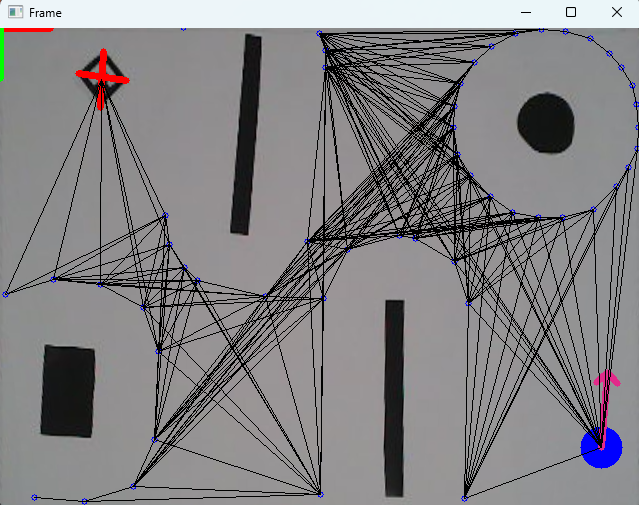

In [ ]:
img = Image.open("images/all_segments.png")
display(img)

Weakness: In the visibility graph implementation, we encountered a specific issue when recalculating the path dynamically, such as when the final destination is moved. If the robot is following the border of an obstacle at the time of recalculation, it may mistakenly consider itself as being inside the obstacle. This causes the visibility graph to incorrectly allow paths that cross through the obstacle, as the robot's position near the boundary is misinterpreted.

### b. Path planning

We chose to implement the A* algorithm for the path planning because it's very efficient, it also reduces the unnecessary exploration by using the heuristic function.

The algorithm starts by initializing a priority queue with the start node, where each node is scored based on the total cost (f_cost = g_cost + heuristic). At each step, the node with the lowest f_cost is processed. If the goal is reached, the path is reconstructed by tracing back through the came_from dictionary.

For each neighbor of the current node, the algorithm calculates the cost (g_cost). If this cost is lower than a previously recorded cost, the neighbor is updated in the priority queue. The process continues until the goal is reached or no valid path is found, ensuring an optimal path with minimal computation.

Note: This implementation is heavily inspired by the A* algorithm provided in the solution to the 5th exercise session of the Mobile Robotics course.

Example:

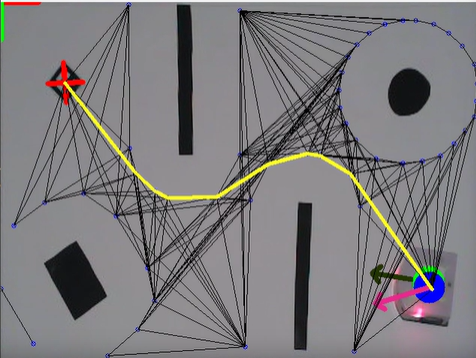

In [ ]:
img = Image.open("images/shortest_path.png")
display(img)

### c. Robot's actuation

This controller ensures the robot follows the optimal path generated by the A* algorithm. The path is divided into segments defined by `nodes_slopes`. The controller adjusts the robot's motor speeds based on its position and orientation relative to the current segment.

`path_direction`
- Checks the robot's progress along the path and transitions it to the next segment when close enough.
- Adjusts motor speeds based on the distance to the target and angular error.

`angle_error`
- Calculates the angular difference between the robot's orientation and the target segment's direction.


This is the final version of our implementation. Initially, our controller did not account for large angle differences, so the robot couldn’t turn quickly enough. As a result, it didn’t follow the planned path accurately and often collided with obstacles. To address this, we added a condition to handle large angle differences. If the angle difference exceeds 10°, the robot first rotates in place until the difference is small enough, after which the controller resumes normal operation.

Additionally, we introduced a constant parameter, Param3, in the speed calculation. Without this constant, the robot's speed became too slow as it neared the end of a segment, making it inefficient. Adding Param3 ensures the robot maintains a minimum speed, improving overall performance and smoothness in reaching the target.

## 4 Local Navigation

Local navigation concerns all the robot's reactions to the stimulation of its on-board sensors. Here, local navigation is triggered by the sudden appearance of obstacles on the map. The on-board sensors detect the obstacle, triggering avoidance.

### a. Obstacles 

**Picture of the obstacles to avoid**

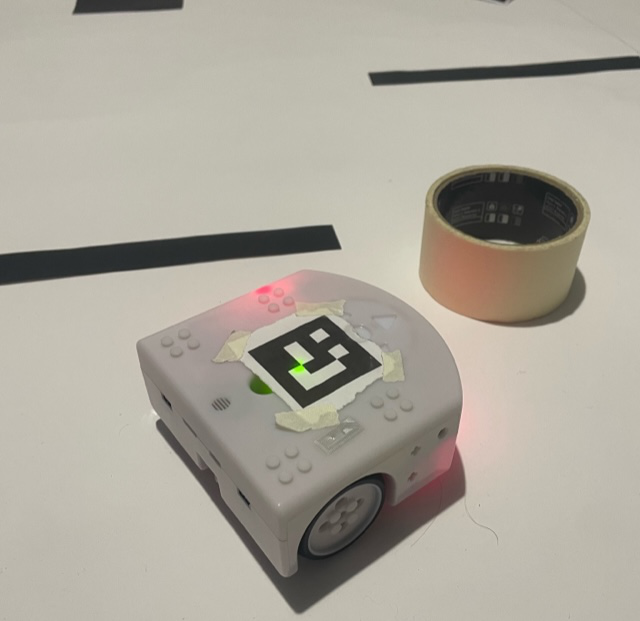

In [ ]:
img = Image.open("images/obstacle.png")
display(img)

To optimize local obstacle avoidance, we decided to use the same object each time. We chose a circular object, as objects with sharp corners are more difficult to avoid. We thus obtained cylindrical obstacles with a diameter of 9 cm.

### b. Method: Artificial Neural Network

The main purpose of our local navigation is to avoid incoming obstacles that are not mapped by the computer vision. For that, we decided to use the Artificial Neural Network method presented in the "Exercice Session 3" of the EPFL's Mobile Robotics course. We chose this way of proceeding because it allows to consider the informations of all the proximity sensos all at once. Furthermore, it is a good way to adapt the wheels' speed depending on the closeness of an obstacle as the speeds of the wheels grow linearly with the values of the sensors.

### c. How does the avoidance work?


#### i. Object detection

The first task is to detect the object encountered. The following code perfoms this:

In [ ]:
def object_detection(prox, avoidance_mode, obstacle, obj_right, obstacle_pos, pos):
    '''
    This function checks if there is an obstacle in front of the robot.
    If there is one, it returns the position of the obstacle and the side of the obstacle.

    inputs:
            prox: the proximity sensors' values
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            obstacle: 0 if there is no obstacle, 1 if there is one
            obj_right: 1 if the obstacle is on the right, 0 if it is on the left
            obstacle_pos: the position of the start of the obstacle
            pos: the robot's position

    outputs:
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            obstacle: 0 if there is no obstacle, 1 if there is one
            obj_right: 1 if the obstacle is on the right, 0 if it is on the left
            obstacle_pos: the position of the start of the obstacle
    '''
    obstThrH = 20           # High threshold for which the robot enters the avoidance obstacle
    
    for i in range (5):     # find if the obstacle is on the left or on the right
        if prox[i] > obstThrH:
            obstacle = 1
            if avoidance_mode == 0:
                obstacle_pos = pos
                avoidance_mode = 1
                if i in [3,4]:
                    obj_right = 1
                if i in [0,1,2]:
                    obj_right = 0  
    return avoidance_mode, obstacle, obj_right, obstacle_pos

For this step, we detect if an obstacle is present or not. The robot goes into "avoidance mode", if it is not already the case, if an obect is detected. Furthermore, if th robot just encountered the obstacle for the first time(ie. "avoidance_mode" is equal to 0 before the iteration), the position of the obstacle is saved in order to know the distance between the robot and the obstacle during the avoidance. 


Finally, the localisation relative to the robot of the obstacle is stocked in the variable "obj_right", which is set to True if the object is at the right and False if the object is at the left of the robot. It allows to know if the robot has to go around the left side or the right side of the obstacle.

#### ii. Transition from Local to Global navigation 

The second important function in the Local Navigation mode is the one that verifies if yes or not we reached the original path (meaning that the robot is past the obstacle). This function is called "segment_check": 

In [ ]:
def segment_check(path, pos, avoidance_mode, segment_index, obstacle, obstacle_pos):
    ''' 
    This function checks if the robot is on a segment of the global path
    and if it is, it returns the index of the segment.

    inputs:
            path: matrix of the global path
            pos: the robot's position
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            segment_index: the index of the segment, from the path, the robot is currently on
            obstacle: 0 if there is no obstacle, 1 if there is one
    
    outputs:
            segment_index: the index of the segment, from the path, the robot is currently on
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            obstacle: 0 if there is no obstacle, 1 if there is one
    '''

    error = [10,25]                   # Error on the position of the robot
    distance_to_obstacle = np.linalg.norm(pos - obstacle_pos)
    print('distance_to_obstacle', distance_to_obstacle)
    for i in range (0, path.shape[0]-1):
        alpha = path[i,2]
        beta = path[i,3]
        x_path = [path[i,0]-error[0], path[i+1,0]+error[0]]
        y_path = [path[i,1]-error[1], path[i+1,1]+error[1]]
        x_path.sort()
        y_path.sort()

        if ((x_path[0] <= pos[0] <= x_path[1]) and (y_path[0] <= pos[1] <= y_path[1])):
            pose_y_min = pos[1] - error[1]
            pose_y_max = pos[1] + error[1]

            fx_min = alpha * (pos[0] - error[0]) + beta
            fx_max = alpha * (pos[0] + error[0]) + beta

            if alpha < 0:                               # If alpha is negative, we have to inverse the boundaries
                fx_min, fx_max = fx_max, fx_min

            if ((pose_y_min <= fx_max <= pose_y_max) or (pose_y_min <= fx_min <= pose_y_max))and(distance_to_obstacle>30):
                if (avoidance_mode == 0):
                    segment_index = i
                else:
                    avoidance_mode = 0
                    segment_index = i
                    obstacle = 0
    return segment_index, avoidance_mode, obstacle


This function realises a set of successive test for each segment of the path:
- 1. It checks if the robot is in the range of the considered segment. (ie. the coordinates of the robot belongs to the rectangle whose diagonal is the segment itself (with a tolerated error)).
- 2. It checks if the position of the robot satisfies the linear relation between x and y described by the segment. (ie.  (α*x_robot + β) ∈ [y_robot-error ; y_robot+error]).

If boths tests are passed, the function returns the segment that the robot just reached and exits the local navigation mode.

**See the graph behind that illustrates the 2 first steps**

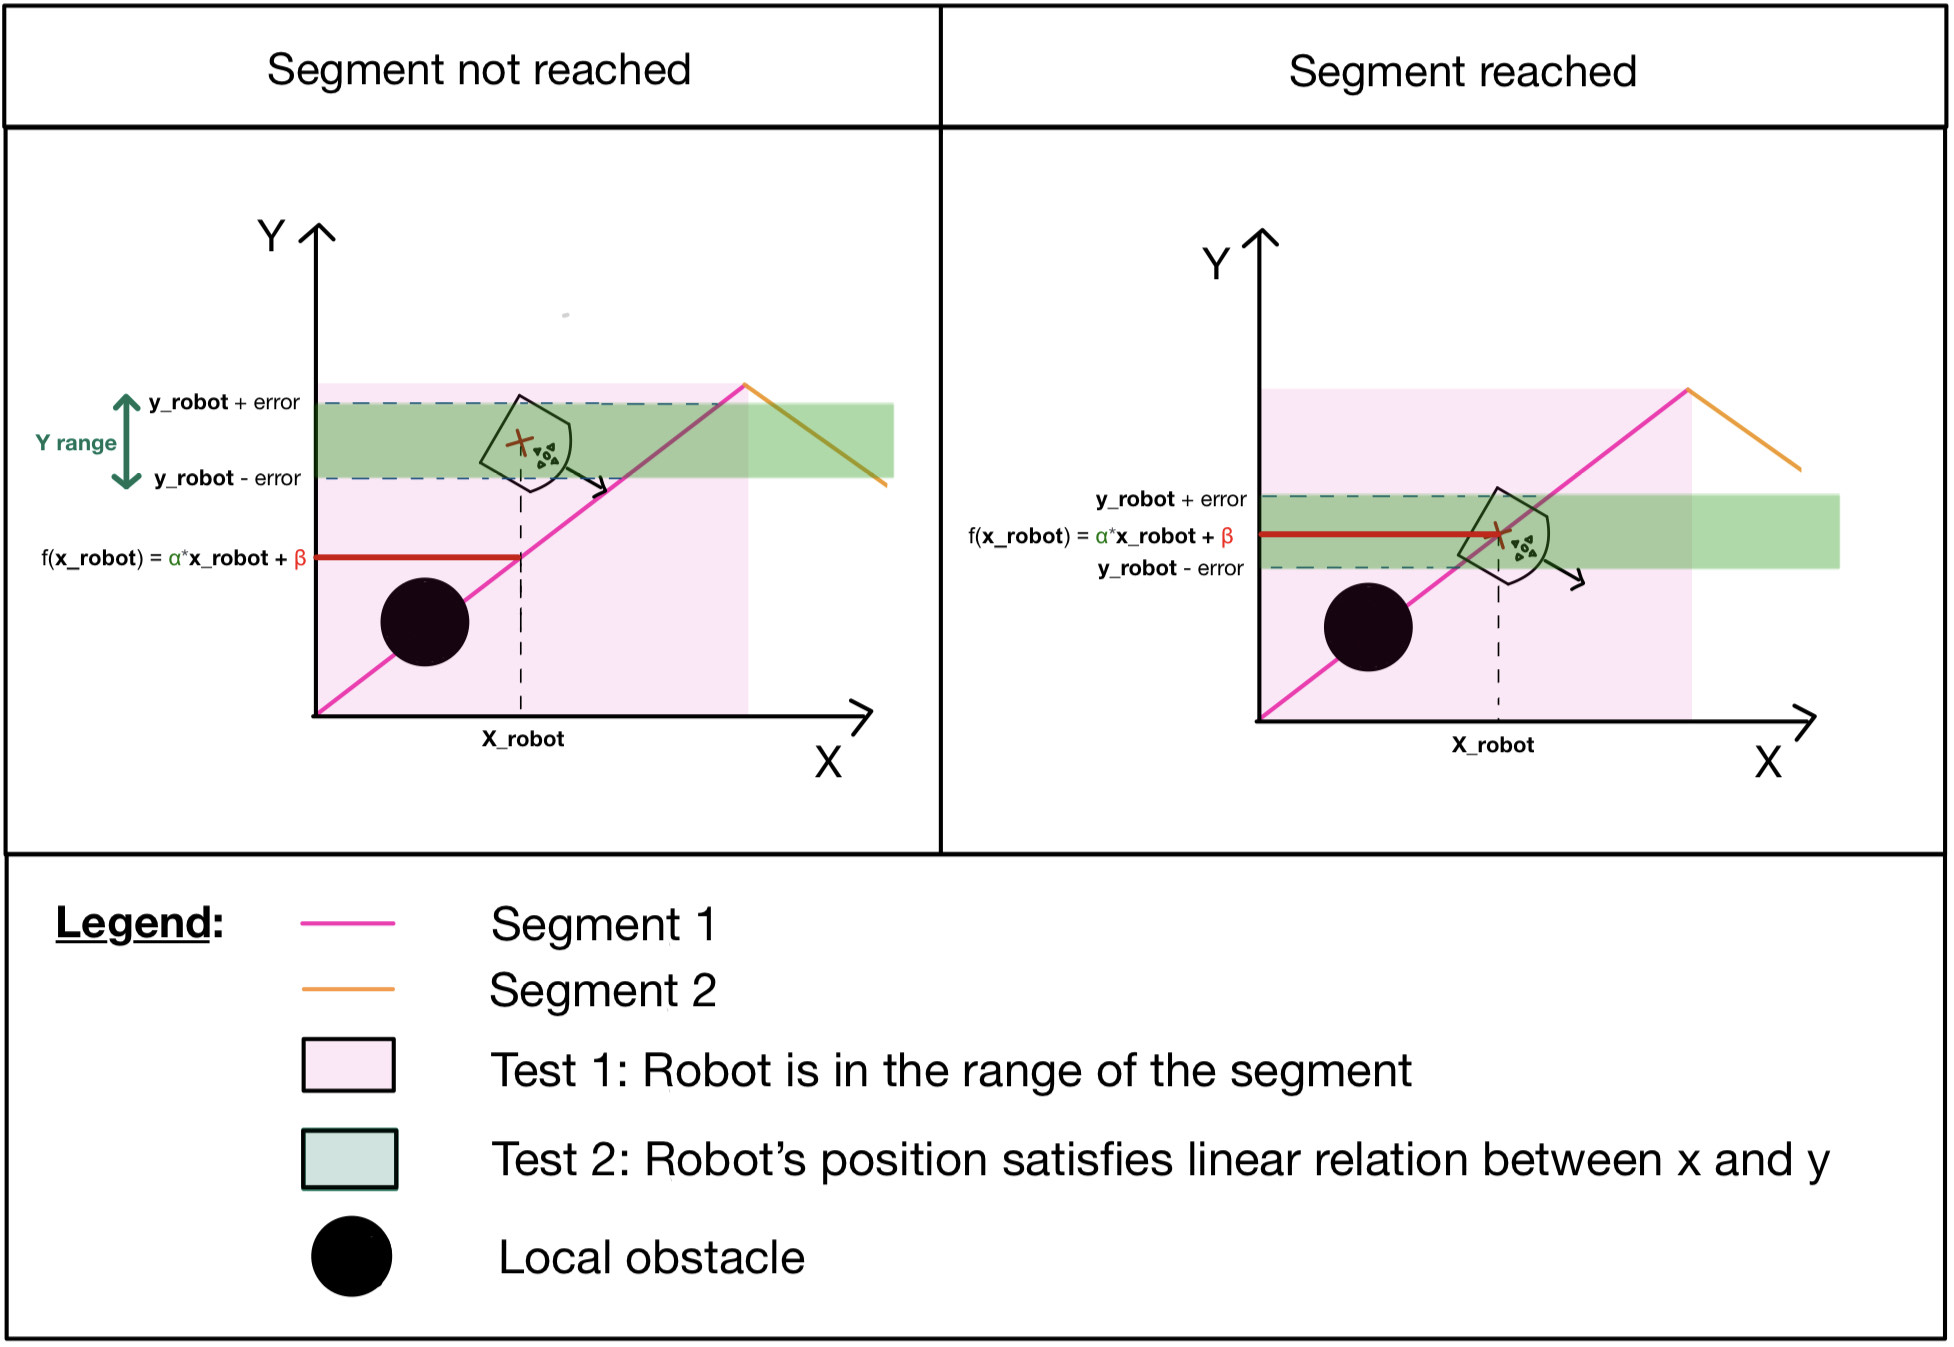

In [ ]:
img = Image.open("images/segment_reached.png")
display(img)

**Double checking the completion of the avoidance:**

Occasionally, coordinate refresh was not fast enough, and the robot missed a path's segment. To overcome this problem, we added another condition to switch from local to global navigation. This condition is to check that the robot has moved far enough away from the obstacle, so that global navigation can resume. We were able to establish the distance limit because we know the size of local obstacles, which is always the same. 

#### iii. Actuation of the motors (Artificial Neural Network)

Here is the code associated to the motors' actuation;

In [ ]:
def actuation_robot(prox, avoidance_mode, obj_right, obstacle, actuation):
    '''
    This function returns the actuation commands to control the wheels' motors
    in order to avoid the obstacle.

    inputs: 
            prox: the proximity sensors' values
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            obj_right: 1 if the obstacle is on the right, 0 if it is on the left
            obstacle: 0 if there is no obstacle, 1 if there is one
            actuation: the actuation commands to control the wheels' motors

    outputs:
            actuation: the actuation commands to control the wheels' motors 
    '''
    w_l_test = [50,  25, -20, 0, 0,  30, -10]
    w_r_test = [0, 0, -20,  25,  50, -10,  30]
    speed_turn_left = [125,300]       #Actuation for turning left
    speed_turn_right = [300,125]      #Actuation for turning right
    x = [0,0,0,0,0,0,0]
    sensor_translation = 350

    if (avoidance_mode == 1):
        if obstacle == 0:
            if (obj_right == 1):
                actuation[0] = speed_turn_right[0]
                actuation[1] = speed_turn_right[1]
            else:
                actuation[0] = speed_turn_left[0]
                actuation[1] = speed_turn_left[1]
        else:
            for i in range (6):
                x[i] = prox[i] // sensor_translation
                actuation[0] = actuation[0] + x[i] * w_l_test[i]
                actuation[1] = actuation[1] + x[i] * w_r_test[i]
    return actuation

First of all, the command sent to the motors (stored in the array "Actuation") is only modified if the avoidance_mode is True (ie. The avoidance mode is activated). Otherwise, the actuation will be set by the global navigation module. Now, if the avoidance_mode is true, there are two cases:
- 1. An obstacle can be seen: artificial neural network links the proximity sensors signals and the commands sent to the motors. It sends actuation values to the wheels in order to dodge the obstacle in an adapted way (thanks to the weights choice). 
- 2. The obstacle is in the blind spot of the robot: the robot uses the variable "obj_right" (presented in section 4.b.i) to knoww on which side it has to fall back. If obj_right is True (meaning that the object is on the right), the robot falls back on its right side. Otherwise, it falls back on the left side. 

NB: (The Artificial Neural Network method used in the project is strongly inspired by the Exercice Session 3 of EPFL's Mobile Robotics course [1])

### c. Limits of the obstacle avoidance module

The obstacle avoidance module works very well but still presents some limits. The main problem is that the robot bypasses the obstacle on the left or right, without taking into account the fact that there may be a global obstacle on that side. Thus, the robot perfectly avoids local obstacles presented when they are placed on the same side as the global obstacle, but reacts less well when it finds itself wedged between a global and a local obstacle.

To overcome this problem, we could have strengthened communication between global navigation and the camera's vision, which detects global obstacles. In this way, we could have predicted the path to be taken by the Thymio to dodge the obstacle, and then checked that it did not cross any fixed obstacles.

## 5. Sensor fusion

### a. System Modelisation

To determine the robot's law of control, it is first important to set the system modelisation. The figure below shows the robot model:

<img src="Images/thymio_modelisation.jpeg" alt="Alt text" width="600"/>

The robot's relevant physical characteristics are the following:

\begin{array}{|c|c|c|}
\hline
\textbf{Robot's characteristic} & \textbf{Variable} & \textbf{Value} \\ \hline
\text{Wheel axle length}        & L               &\text{9.5 [cm]}              \\ \hline
\end{array}

Therefore, its linear and angular velocities are as follow:
$$ v = \frac{1}{2}(v_l+v_r) $$
$$ \omega = \frac{1}{2L}(v_l-v_r) $$

Because the position of the robot is measured in pixels by the camera during the simulation, the velocities were converted in pixels. First of all, from the Thymio's datasheet [2, https://moodle.epfl.ch/pluginfile.php/2706097/mod_resource/content/1/ThymioCheatSheet.pdf], a speed conversion coefficient was determined, such that:
$$
[v_l, v_r] = [500, 500] \approx 20 \text{[cm/s]} \implies \text{speed-coeff} = 0.04 
$$

Then, a conversion from cm to pixel was determined fron the characteristics of our scene, such that:
$$
\text{pixel-per-cm-coeff} = \frac{\text{scene-width-px}}{\text{map-width-cm}} =  \frac{640}{97.2} \approx 6.58 \ \text{[px/cm]} 
$$

Therefore, the relevant conversion coefficients are as followed:
\begin{array}{|c|c|c|}
\hline
\textbf{Conversion coefficient} & \textbf{Variable} & \textbf{Value} \\ \hline
\text{Speed coefficient}            & speed-coeff               &\text{0.04 [-]}              \\ \hline
\text{Pixel per cm coefficient}        & pixel-per-cm-coeff               &\text{6.58 [px/cm]}              \\ \hline
\end{array}

Thus, the velocities and the robot physical characteristics were converted to get the relevant units from the pose measured by the camera in pixel. 

### b. Control Law

Thus, the control law of the mobile robot is the following:

$$ \overrightarrow{x_{k+1}} = A\overrightarrow{x_k} + B\overrightarrow{u_k} + \overrightarrow{\omega_k} $$
$$ \overrightarrow{y_{k}} = C\overrightarrow{x_k} + \overrightarrow{\nu_k} $$

Where the state variables and the command inputs are respectively the position and the linear and angular velocities, such that:
$$\overrightarrow{x}=
\begin{bmatrix}
p_x \\
p_y \\
\theta
\end{bmatrix},
\overrightarrow{u} = 
\begin{bmatrix}
v \\
\omega \\
\theta
\end{bmatrix}$$

The dynamic for each state variables are the following:
$$ p_{x_{k+1}} = f_1(v, \omega) = p_{x_k} + v \Delta t \cos(\theta_k) $$
$$ p_{y_{k+1}} = f_2(v, \omega) = p_{y_k} + v \Delta t \sin(\theta_k) $$
$$ \theta_{k+1} = f_3(v, \omega) = \theta_{k} + \omega \Delta t $$

Thus:
$$ \overrightarrow{x_{k+1}} = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
p_{x_k} \\
p_{y_k} \\
\theta_{k}
\end{bmatrix}

+\Delta t\begin{bmatrix}
\cos(\theta_{k}) & 0\\
\sin(\theta_{k}) & 0\\
0 & 1
\end{bmatrix}

+\omega_k$$

$$ \overrightarrow{y_k} = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
p_{x_k} \\
p_{y_k} \\
\theta_{k}
\end{bmatrix}

+\nu_k$$

Finally, it is important to determine the covariance matrices of the prediction and measurement noise, such that respectively:
$$Q =
\begin{bmatrix}
\text{var}(p_x) & \text{cov}(p_x, p_y) & \text{cov}(p_x, \theta) \\
\text{cov}(p_x, p_y) & \text{var}(p_y) & \text{cov}(p_y, \theta) \\
\text{cov}(p_x, \theta) & \text{cov}(p_y, \theta) & \text{var}(\theta)
\end{bmatrix},\

R =
\begin{bmatrix}
r_{p_x} & 0 & 0 \\
0 & r_{p_y} & 0 \\
0 & 0 & r_\theta
\end{bmatrix}$$



### c. Prediction and measurement covariances matrices

The system explained above is non-linear and a linearization inspired from the first order Taylor series approximation [3, https://en.wikipedia.org/wiki/Propagation_of_uncertainty] was made for each state equations, in order to determine the prediction variances. Therefore, the linearized state equations are the following:

$$
p_{x_{k+1}} \approx f_1(v, \omega)^0 +
\frac{\partial f_1}{\partial v} v +
\frac{\partial f_1}{\partial \omega} \omega
$$

$$
p_{y_{k+1}} \approx f_2(v, \omega)^0 +
\frac{\partial f_2}{\partial v} v +
\frac{\partial f_2}{\partial \omega} \omega
$$

$$
\theta_{k+1} \approx f_3(v, \omega)^0 +
\frac{\partial f_3}{\partial v} v +
\frac{\partial f_3}{\partial \omega} \omega
$$

Then, the partial derivatives are:

$$
\frac{\partial f_1}{\partial v} = \Delta t \cos(\theta_k), \quad \frac{\partial f_1}{\partial \omega} = 0, \\

\frac{\partial f_2}{\partial v} = \Delta t \sin(\theta_k), \quad \frac{\partial f_2}{\partial \omega} = 0, \\

\frac{\partial f_3}{\partial v} = 0, \quad \frac{\partial f_3}{\partial \omega} = \Delta t
$$

Hence, for the variances, we get:

$$
\text{var}(p_{x_{k+1}}) \approx \left( \frac{\partial f_1}{\partial v} \right)^2 \text{var}(v) = \Delta t^2 \cos^2(\theta_k) \text{var}(v)
$$

$$
\text{var}(p_{y_{k+1}}) \approx \left( \frac{\partial f_2}{\partial v} \right)^2 \text{var}(v) = \Delta t^2 \sin^2(\theta_k) \text{var}(v)
$$

$$
\text{var}(\theta_{k+1}) \approx \left( \frac{\partial f_3}{\partial \omega} \right)^2 \text{var}(\omega) = \Delta t^2 \text{var}(\omega)
$$

Finally, for the covariances, we get:

$$
\text{cov}(p_y, p_x) = \text{cov}(p_x, p_y) \approx (\frac{\partial f_1}{\partial v}) (\frac{\partial f_2}{\partial v}) \text{var}(v) = \Delta t^2 \cos(\theta_k) \sin(\theta_k) \text{var}(v)
$$

$$
\text{cov}(\rho_x, \theta) = \text{cov}(\theta, \rho_x) = 0
$$

$$
\text{cov}(\rho_y, \theta) = \text{cov}(\theta, \rho_y) = 0
$$

### d. Experimental measures

The measured variances for the robot's pose and velocities were found by experimentation.

First of all, for the robot's pose variances, the Thymio was placed on the scene and detected by the camera. The variances for the positions and the angle were then determined from the following plots:


<table style="width:100%; text-align:center;">
  <tr>
    <td>
      <img src="Images/Kalman/px_cov.png" alt="px_cov" width="400"/>
    </td>
    <td>
      <img src="Images/Kalman/py_cov.png" alt="py_cov" width="400"/>
    </td>
  </tr>
  <tr>
    <td colspan="2" style="text-align:center;">
      <img src="Images/Kalman/py_cov.png" alt="py_cov" width="400"/>
    </td>
  </tr>
</table>

$$
\\
\text{var}(p_{x}) = 0.0048 \ \text{[px]}^2, \text{var}(p_{y}) = 0.0095 \ \text{[px]}^2, \
\text{var}(\theta) = 0.0002 \ \text{[rad]}^2
$$

Then, the variances from the motors raw velocities were determined from the following plots:

<table style="width:100%; text-align:center;">
  <tr>
    <td>
      <img src="Images/Kalman/vl_cov.png" alt="vl_cov" width="400"/>
    </td>
    <td>
      <img src="Images/Kalman/vr_cov.png" alt="vr_cov" width="400"/>
    </td>
  </tr>
</table>

$$
\\
\text{var}(raw-v_l) = 78.53 \implies \text{var}(v_l) = 5.44 \ \text{[px/s]}^2 \
\text{var}(raw-v_r) = 33.79 \implies \text{var}(v_l) = 2.34 \ \text{[px/s]}^2 \
$$



### e. Implementation of the Kalman Filter

We chose the Kalman filter because it’s great for estimating the robot's position and orientation when dealing with noise and uncertainty. It combines the robot's previous state (from odometry) with new sensor measurements to give a more accurate estimate of its current state.

Description of the algorithm:
- The prediction step uses the wheel’s movement to estimate where it should be, even if no new measurements are available.
- The update step corrects this estimate using camera data, taking into account how reliable those measurements are. For example, if the camera is blocked, the algorithm increases the uncertainty.

This makes the Kalman filter ideal for handling noisy environments and ensuring the robot stays on track, even when the camera data is missing.

Note: This implementation of the Kalman filter is heavily inspired by the algorithm provided in the Mobile Robotics class, specifically the solutions from exercise session 7.

## 6. Video Demonstrations

### a. Global example

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="videos/global_example.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

### b. Specific cases

#### i. Normal path

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="videos/normal_path.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

#### ii. Obstacle avoidance

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="videos/obstacle_avoidance.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

#### iii. Kidnapping

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="videos/kidnapping.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

#### iv. Change in goal's position

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="videos/goal_position.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

#### v. Hidden Camera

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="videos/hidden_camera.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

# 7. Sources

[1] Course "Basics of Mobile Robotics" by Prof. Francesco Mondada (MICRO-452): https://moodle.epfl.ch/course/view.php?id=15293

[2] Shapely : https://shapely.readthedocs.io/en/stable/

[3] Heapq : https://docs.python.org/3/library/heapq.html

[4] Numpy: https://numpy.org/doc/

[5] TDM Client: https://github.com/epfl-mobots/tdm-python/tree/main

[6] OpenCV: https://docs.opencv.org/

[7] Chat-GPT4: https://chat.openai.com/

[8] Wikipedia: https://en.wikipedia.org/wiki/Propagation_of_uncertainty

[9] ArUco markers generator: https://chev.me/arucogen/

[10] Scipy: https://scipy.org

OpenCV functions:

[11] OpenCV Aruco detection functions: https://docs.opencv.org/3.4/d9/d6a/group__aruco.html

[12] OpenCV warpPerspective: https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae

[13] OpenCV Rodrigues: https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html

[14] OpenCV cvtColor: https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html

[15] OpenCV GaussianBlur: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gae8bdcd9154ed5ca3cbc1766d960f45c1

[16] OpenCV Canny: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

[17] OpenCV findContours: https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97…